In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #for custom legends
import seaborn as sns
from lifelines import KaplanMeierFitter #survival analysis library
from lifelines.statistics import logrank_test #survival statistical testing
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [155]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [3]:
url="https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv?cm_mc_uid=51304980933215218170416&cm_mc_sid_50200000=92178841521817041648&cm_mc_sid_52640000=98592221521817041652"
df = pd.read_csv(url)
print(df.shape)
display_all(df.tail().transpose())

(7043, 21)


,7038,7039,7040,7041,7042
customerID,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD,3186-AJIEK
gender,Male,Female,Female,Male,Male
SeniorCitizen,0,0,0,1,0
Partner,Yes,Yes,Yes,Yes,No
Dependents,Yes,Yes,Yes,No,No
tenure,24,72,11,4,66
PhoneService,Yes,Yes,No,Yes,Yes
MultipleLines,Yes,Yes,No phone service,Yes,No
InternetService,DSL,Fiber optic,DSL,Fiber optic,Fiber optic
OnlineSecurity,Yes,No,Yes,No,Yes


In [4]:
df["b_Churn"] = df.Churn.apply(lambda x: 1 if x == "Yes" else 0) #recode churn var

In [5]:
df.MultipleLines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [6]:
#drop "No phone service"
df[df.MultipleLines != "No phone service"]

#recode MultipleLines var to get our two comparison cohorts
df["b_MultipleLines"] = df.MultipleLines.apply(lambda x: 1 if x == "Yes" else 0)

In [42]:
#this is not time series data, so we will assume all customers start at t = 0 
# and continue until t = tenure
df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

# Kaplan-Meier
For background, see [Rich et al (2010)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3932959/), [Singh et all (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3227332/)
+ Estimates the “survival function” via the for a cohort of subjects 
+ Does not provide an estimate of the magnitude of the difference in survival for the cohorts being compared 
+ Each observation (case, customer) should have one "birth" (activation) and one "death" (churn)

In [35]:
kmf = KaplanMeierFitter()
T = df['tenure'] #duration
C = df["b_Churn"] #censorship - 1 if death/churn is seen, 0 if censored

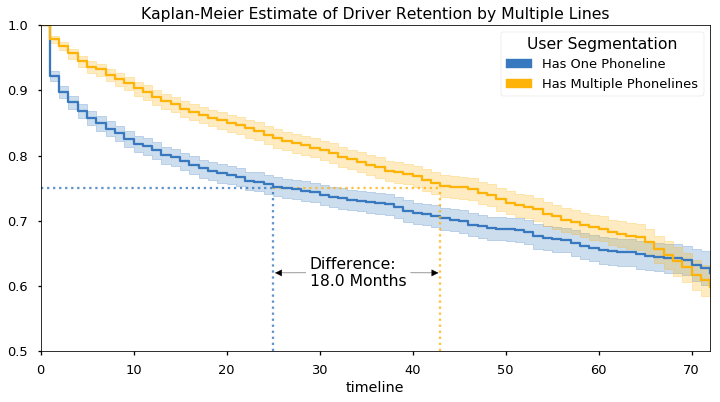

In [157]:
palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0

##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
for segment in df.b_MultipleLines.unique(): 
    ix = df.b_MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))

    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    
    vlines.append([y_, ymax_])
    i+=1

##PLOT ANNOTATION
#for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

## position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

#label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )

#label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )

##LEGEND
#override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');

The graph clearly shows that there is a difference in tenure between "single line" and "multiple line" telco users. Since the confidence interals also appear on the graph, we can see that the difference is statistically significant from t > 0 until approximately t= 52 months, after which the churn rates becomes the same, within the margin of error. 

Our survival curves do not follow the constant proportionality assumption (they cannot because they cross, and we can also see varying distances between the curves throughout). Conventionally, ths would mean that a logrank test is not an appropriate measure for estimating the hazard ratio. This [presentation by Stone (2015)](http://bbs.ceb-institute.org/wp-content/uploads/2016/06/Andy-Stone-Non-Proportional-Hazards-So-What.pdf) makes a compelling argument that hazard ratios on nonproportionality are still readily interpretable. This has, however, been a source of controversy in the biostatistics field. Alternative methods such as time-splitting have been proposed, see: [Bouliotis &amp; Billingham (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3287712/)

To get the hazard ratio, we run the logrank test.

In [138]:
multi = (df["b_MultipleLines"] == 1)
results = logrank_test(T[multi], T[~multi], C[multi], C[~multi], alpha=0.99 ) #at 99% confidence level
results.print_summary()


df=1, alpha=0.99, null_distribution=chi squared, t_0=-1

test_statistic      p     
       24.8504 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [153]:
# Image Credit: https://en.wikipedia.org/wiki/Log-rank_test
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/68750c8d50ac1d055b3ddcc67a05de43b40fdebf")

In [152]:
Z = results.test_statistic
D = C.sum() #number of events observed

hazard_ratio = np.exp(Z*np.sqrt(4/D))
print(hazard_ratio)

3.15703557409


Therefore the risk of churn is 3.2 times higher in users with only one phoneline compared to users with multiple lines.